# Sentinel Hub

Sentinel Hub is a platform that provides access to a wide range of satellite data, including Sentinel-1, Sentinel-2, and Sentinel-3. It also provides access to other data sources such as DEM, Landsat, MODIS, and more. Visit the [Sentinel Hub website](https://www.sentinel-hub.com/) for more information.  
***You will need to create an account to access the data.***

In [176]:
# Import the necessary libraries
# Also configure the environment variables for Sentinel Hub

In [177]:
from sentinelhub import SHConfig
import geopandas as gpd
import os
from dotenv import load_dotenv
import rioxarray as rxr

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# Load environment variables
load_dotenv('.environ')
SH_CLIENT_ID = os.getenv("SH_CLIENT_ID")
SH_CLIENT_SECRET = os.getenv("SH_CLIENT_SECRET")

# Set the configuration
config = SHConfig()
config.sh_client_id = SH_CLIENT_ID
config.sh_client_secret = SH_CLIENT_SECRET
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [178]:
for collection in DataCollection.get_available_collections():
    print(collection)

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL
DataCollection.dem
DataCollection.dem_mapzen
DataCollection.dem_30


In [179]:
# Load the fleurie geojson file, our area of interest
fleurie_path = 'data/geojson/fleurie-communes.geojson'
fleurie = gpd.read_file(fleurie_path)

In [180]:
# CRS of the AOI must be WGS84
fleurie.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [181]:
# create a bounding box
total_bounds = tuple(fleurie.total_bounds)
fleurie_bbox = BBox(bbox=total_bounds, crs=CRS.WGS84)
# define a resolution of 20 meters
resolution = 20
# and also the size
fleurie_size = bbox_to_dimensions(fleurie_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {fleurie_size} pixels")

Image shape at 20 m resolution: (235, 243) pixels


In [182]:
evalscript_dem = """
//VERSION=3
function setup() {
  return {
    input: ["DEM"],
    output: {
        id: "default", 
        bands: 1,
        sampleType: SampleType.FLOAT32
    }
  };
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
"""

dem_request = SentinelHubRequest(
    evalscript=evalscript_dem,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM.define_from("dem", service_url=config.sh_base_url),
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=fleurie_bbox,
    size=fleurie_size,
    config=config,
)
dem_request.data_folder = "data/tiff/dem"

dem_data = dem_request.get_data(save_data=True)

In [183]:
len(dem_data)

1

In [184]:
dem_arr = dem_data[0].squeeze()

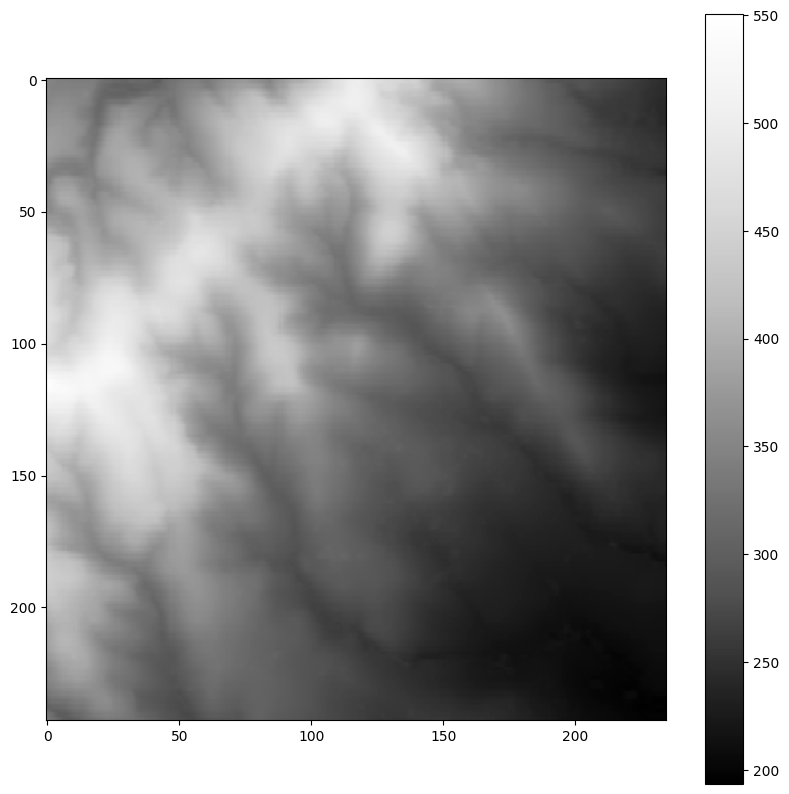

In [185]:
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(dem_arr, cmap="Greys_r")
cbar = fig.colorbar(img, ax=ax)
plt.show()

In [186]:
# try to open the file with rioxarray
dem_arr_rio = rxr.open_rasterio("data/tiff/dem/f49c10fb75c19ee690572f9894c0f3c9/response.tiff")

In [187]:
dem_arr_rio.rio.crs

CRS.from_epsg(4326)

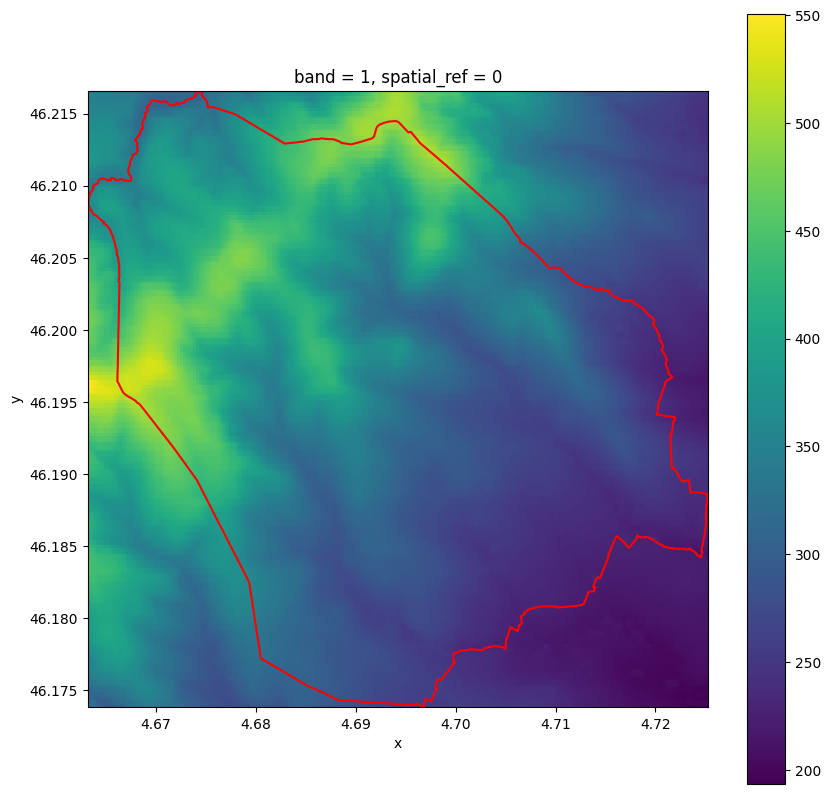

In [188]:
# plot the dem raster with the fleurie boundary
fig, ax = plt.subplots(figsize=(10, 10))
dem_arr_rio.plot(
    ax=ax
)
fleurie.boundary.plot(ax=ax, edgecolor='red')
plt.show()


In [189]:
# What the most elevated point in the area?
max_elevation = dem_arr_rio.data.max()
max_elevation

550.55975

In [190]:
# clip the raster to the area of interest
dem_arr_clip = dem_arr_rio.rio.clip(fleurie.geometry)

In [191]:
# Get the max elevation position
max_elevation_pos = dem_arr_clip.where(dem_arr_clip == dem_arr_clip.max(), drop=True).squeeze()
# Get the max elevation coordinates and value
max_elevation_x, max_elevation_y, max_elevation = max_elevation_pos.x.item(), max_elevation_pos.y.item(), max_elevation_pos.values.item()

In [192]:
# Same for the min elevation
min_elevation_pos = dem_arr_clip.where(dem_arr_clip == dem_arr_clip.min(), drop=True).squeeze()
min_elevation_x, min_elevation_y, min_elevation = min_elevation_pos.x.item(), min_elevation_pos.y.item(), min_elevation_pos.values.item()

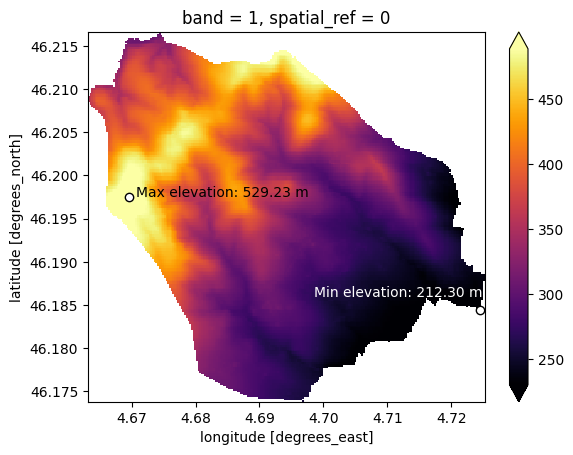

In [193]:
# plot the max elevation
fig, ax = plt.subplots()
# Robust: this will use the 2nd and 98th percentiles of the data to compute the color limits
dem_arr_clip.plot(cmap='inferno', robust=True, ax=ax)
# plot the max elevation
ax.scatter(max_elevation_x, max_elevation_y, color='w', edgecolor='k')
# plot the min elevation
ax.scatter(min_elevation_x, min_elevation_y, color='w', edgecolor='k')

# annot the max elevation
ax.annotate(f"Max elevation: {max_elevation:.2f} m", (max_elevation_x + .001, max_elevation_y), color='k')
# annot the min elevation
ax.annotate(f"Min elevation: {min_elevation:.2f} m", (min_elevation_x - .026, min_elevation_y + 0.0015), color='w')
plt.show()

In [200]:
# function to calculate hillshade
def hillshade(
        array: np.ndarray,
        azimuth: float,
        angle_altitude: float
) -> np.ndarray:
    """
    Calculate hillshade
    :param array: dem array
    :param azimuth: azimuth angle in degrees
    :param angle_altitude: altitude angle in degrees
    :return: hillshade array
    """
    # convert the azimuth to 0-360 degrees
    azimuth = 360.0 - azimuth 
    
    # convert values to radians
    x, y = np.gradient(array)
    # calculate the slope in radians
    slope = np.pi / 2. - np.arctan(np.sqrt( x * x + y * y))
    # calculate the aspect in radians
    aspect = np.arctan2(-x, y)
    # calculate the shaded relief in radians
    azm_rad = azimuth * np.pi / 180.
    # calculate the altitude in radians
    alt_rad = angle_altitude*np.pi / 180.
    # calculate the shaded relief
    # 
    shaded = np.sin(alt_rad)*np.sin(slope) + np.cos(alt_rad)*np.cos(slope)*np.cos((azm_rad - np.pi/2.) - aspect)
    
    return 255 * (shaded + 1) / 2

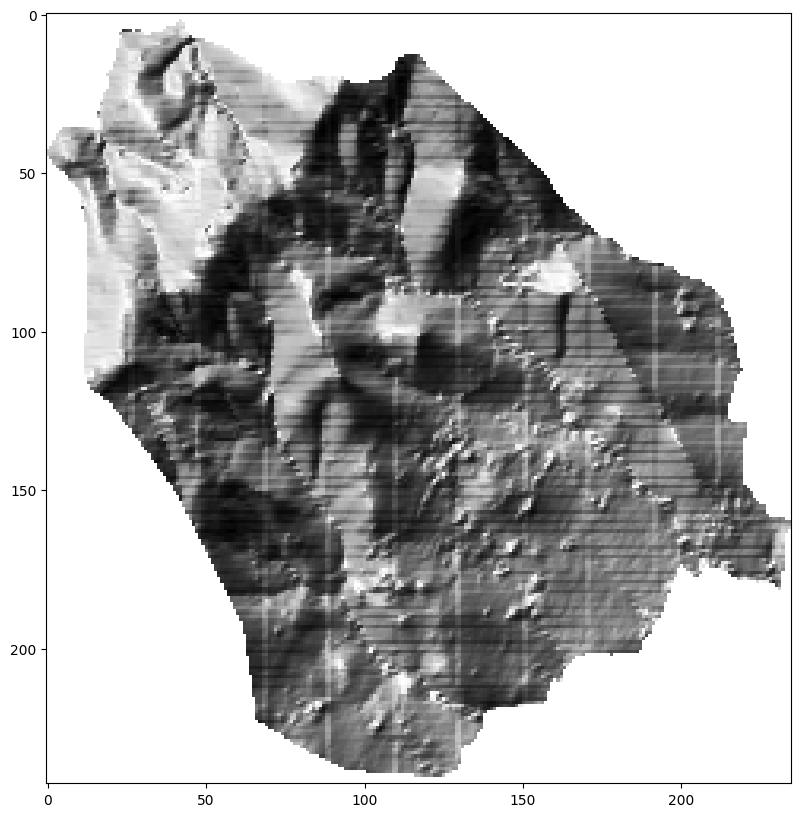

In [201]:
# calculate the hillshade
hillshade_arr = hillshade(dem_arr_clip.values[0], 315, 45)

# plot the hillshade
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(hillshade_arr, cmap='gray')
plt.show()